In [1]:
## Import libraries ##
import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd

In [2]:
## Define Basic functions ##

#generate points that aren't too close to each other
def generate_points(minX, maxX, N, dim = 1):
    min_distance = np.abs(maxX-minX)/(2*N)
    print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(minX, maxX, size=(1,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.abs(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()


#squared expo kernel
def kernel(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo


# Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
def posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
    '''
    
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))
    
    return Xtest, mu, std


#Given test point x (Xtest_val), what is y?
def conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + sigma_n**2*np.eye(N)) 

    ## 3) Predictive mean at test points
    Xtest = np.asarray([Xtest_val]).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))

    return Xtest_val, mu, std


#plot the posterior distribution of GPR
def plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Plot the posterior distribution of GPR
    '''
    #Return mu and std:
    Xtest, mu, std = posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    print("Mean predictive std: ", np.mean(std))
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    #plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()

## Given

Plot of dataset and the function we'd like to estimate (our goal):

0.5


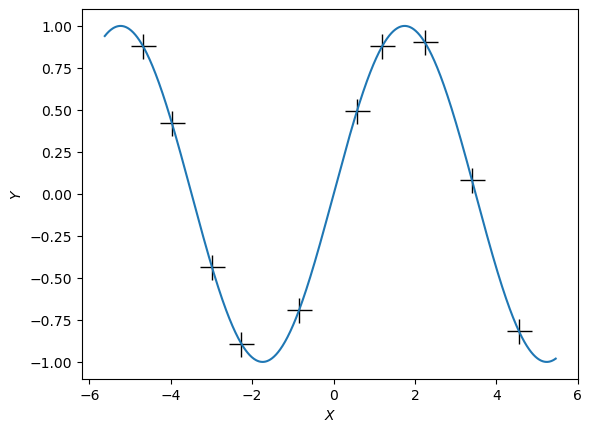

In [3]:
#This is our dataset:
N = 10 
X = generate_points(-5, 5, N, dim = 1)
y = (f(X) + np.random.normal(0,0,N)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Plot of data:
plt.plot(X, y, 'k+', ms=18)

#Function we'd like to estimate --> our goal
x = np.arange(min(X)-abs(min(X))*0.2, max(X)+abs(max(X))*0.2, 0.01).reshape(-1,1)
f_x = f(x)

#Render plots
plt.plot(x, f_x)
plt.axis([min(x)-abs(min(x))*0.1, max(x)+abs(max(x))*0.1, min(f(x))-abs(min(f(x)))*0.1,  max(f(x))+abs(max(f(x)))*0.1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

and we'll use this kernel in our GP:

We use the _Squared Exponential Kernel_, also called Radial Basis Function Kernel or Gaussian Kernel, as our covariance function:
\begin{equation}\label{eq:1}
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
\end{equation}
where the signal variance $\sigma_f^2$ (signal standard deviation $\sigma_f$) and the length scale $l$ are _hyperparameters_ which we'll want to optimize. In this example, this would result in a $n$x$n$ positive-definite covariance matrix $K$ where each element is $\kappa(x_i,x_j)$ with $x_i,x_j$ taken from the $n$ evenly spaced $x$ values for all $i,j\in \{1\ldots,n\}$.

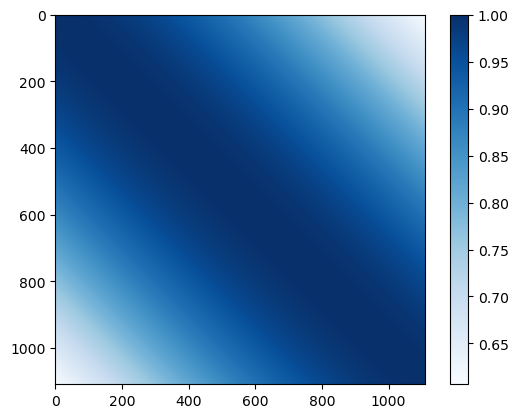

In [4]:
#Plot of kernel
x = x.reshape(-1,1)
x = (x - np.min(x))/(np.max(x) - np.min(x)) #X in [0,1]
K = kernel(x, x, 1, 1)

plt.imshow(K, cmap = 'Blues', interpolation = 'nearest')
plt.colorbar()
plt.show()

Normalize data:

In [5]:
#Normalize feature:
X = (X - np.min(X))/(np.max(X) - np.min(X)) #X in [0,1]

#Normalize target:
#y = (y - min(y))/(max(y)-min(y))

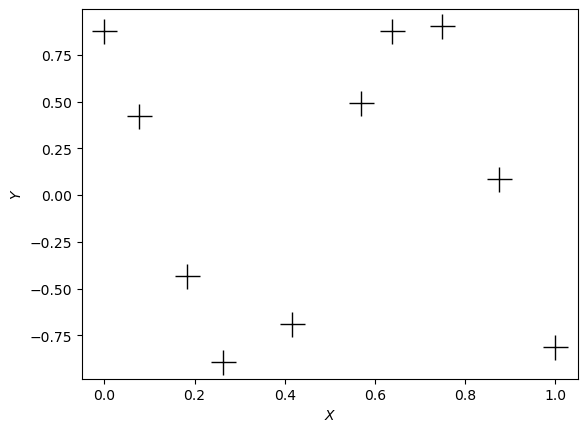

In [6]:
#Plot
plt.plot(X, y, 'k+', ms=18) #data points

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

Initial parameter guesses

In [7]:
#Initial guesses#
init_sigma_n = 0.0001 #np.std(y) # guess for observation noise
init_len_scale = 0.5
init_sigma_f = (np.abs(np.min(y)) + np.abs(np.max(y)))/2 #this is the semi-range

init_par = [init_sigma_n, init_len_scale, init_sigma_f]
init_par #these are the optimum parameters

[0.0001, 0.5, 0.8989328668516184]

## 5.2 Method 1: Bayesian Model Selection

While there are many variations to model selection, most fall under one of three principles:

1) Find the probability of the model given the data. Ex: Bayesian model selection.

2) Estimate the generalization error. Ex: cross-validation.

3) Bound the generalization error.

The generalization error is the average error on test cases, following the same distribution as the training dataset. We do not aim for low training error since any model may fit the noise in the training set, leading to low training noise but high generalization error, which is an over-fit.

<br><br>
Sources used:
* Rasmussen and Williams, _Gaussian Process for Machine Learning_; pp. 108

The Bayesian view on model selection computes the probability of the model given the data via the marginal likelihood. We use a Bayesian treatment of the parameters as it views any uncertainties (like the parameters, hyperparameters, and models) as random variables with prior distributions.
- It's common practice to use **Bayesian hierarchical modelling**. This is where lowest level are the parameters $w$, like the coefficient parameters in a linear model or the weights in a neural network, the second level are the hyperparameters $\theta$ which determine the distribution of the parameters $w$, like the ''weight decay" term in a neural network or the $\lambda$ term in ridge regression, and the third level may be the set of models, like the choice of kernels.
<br><br>
Bayesian inference (levels 1 to 3):
1. Bayes' rule for the posterior over the parameters: 
$$
p(w\vert y, X, \theta, H_i) = \frac{p(y\vert X, w, H_i)p(w\vert \theta, H_i)}{p(y\vert X, \theta, H_i)}
$$
where $p(y\vert X, w, H_i)$ is the likelihood, $p(w\vert \theta, H_i)$ is the prior, and $p(y\vert X, \theta, H_i)$, which is independent of the parameters, is the marginal likelihood (which we've introduced before):
$$
p(y\vert X, \theta, H_i) = \int p(y\vert X, w, H_i)p(w\vert \theta, H_i) dw
$$
<br><br>
2. Bayes' rule for the posterior over the hyperparameters: here the marginal likelihood from 1. takes the role of the likelihood:
$$
p(\theta\vert y,X,H_i) = \frac{p(y\vert X,\theta,H_i)p(\theta\vert H_i)}{p(y\vert X,H_i)}
$$
where $p(\theta\vert H_i)$ is the hyper-prior (prior distribution for hyperparameters) and the marginal likelihood
$$
p(y\vert X, H_i) = \int p(y\vert X,\theta,H_i)p(\theta\vert H_i) d\theta
$$
3. Bayes' rule for the posterior over the models:
$$
p(H_i\vert y, X) = \frac{p(y\vert X, H_i)p(H_i)}{p(y\vert X)}
$$
where 
$$
p(y\vert X) = \sum_i p(y\vert X,H_i)p(H_i)
$$
<br><br>

The integrals above may or may not be analytically solvable, so in general we must resort other methods like Markov chain Monte Carlo (MCMC).

<br><br>
Sources used:
* Rasmussen and Williams, _Gaussian Process for Machine Learning_; pp. 109

### Exercise

**Exercise:** AME 565 Lab - Maximum Likelihood and Bayesian update

1) Generate $N$ sampes from a normal distribution with mean $1$ and standard deviation $2$. Using maximum likelihood estimation (MLE), find an estimate of the mean and standard deviation. Use an array of value estimates. Start with $N=5$ and increase gradually

2) Consider an exponential distribution of parameter $\lambda = 2$ that we want to estimate based on $N$ observations. First estimate $\lambda$ through MLE. Then use Bayesian update to find a distribution between $1$ and $3$ with standard deviation of $0.5$. In each case, find the maximum of the posterior using an array of $\lambda$ values.

3) Redo 1) and 2) but optimize the MLE

#### 1.

In [8]:
# Given:
N1 = 5
X1 = np.random.normal(1, 2, N1)

We take $N$ samples $X_i\sim N(1,2^2)$. The pdf of $X_i$ is:
$$
f(x_i) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)
$$
We want to estimate the mean $\mu_0$ and variance $\sigma_0^2$ using the MLE.
<br>
The likelihood of these $N$ samples is
$$
L(\mu,\sigma^2\vert x_1,\ldots,x_N) = \prod_{i=1}^N f(x_i) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)
$$
$$
= (2\pi\sigma^2)^{-N/2}\exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^N(x_i-\mu)^2\right)
$$
Taking the log of $L$ gives us the log-likelihood:
$$
l(\mu,\sigma^2\vert x_1,\ldots,x_N) = -\frac{N}{2}\ln(2\pi) - \frac{N}{2}\ln(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^N(x_i-\mu)^2
$$
We find the maximum likelihood estimators by solving the maximization problem $\max_{\mu,\sigma^2} l(\mu,\sigma^2,x_1,\ldots,x_N)$. Taking the partial derivative of the log-likelihood with respect to each parameter, setting each to $0$, and solving returns
$$
\hat{\mu_o} = \frac{1}{N}\sum_{i=1}^N x_i
$$
$$
\hat{\sigma_o^2} = \frac{1}{N}\sum_{i=1}^N(x_i - \hat{\mu_o})^2
$$
We use the last two results to estimate the mean and standard deviation of the given sample:

In [9]:
#N=5
mu_o = (1/N1)*np.sum(X1)
sigma_o = np.sqrt( (1/N)*np.sum((X1-mu_o)**2) )
print(mu_o, sigma_o)

0.508170381178077 0.701348565951982


In [10]:
#N=5,...,20
for N1 in range(5,21):
    X1 = np.random.normal(1, 2, N1)
    mu_o = (1/N)*np.sum(X1)
    sigma_o = np.sqrt( (1/N)*np.sum((X1-mu_o)**2) )
    print("N=",N,"mu_0=",mu_o,"sigma_o=",sigma_o)

N= 10 mu_0= 0.27212897332232583 sigma_o= 0.3410159387173972
N= 10 mu_0= 0.39430614553441673 sigma_o= 0.7118442874376985
N= 10 mu_0= -0.17143138512790623 sigma_o= 1.2548177733575177
N= 10 mu_0= 1.953451219762922 sigma_o= 1.4828374065105896
N= 10 mu_0= 0.8307840869950178 sigma_o= 1.3768867104558042
N= 10 mu_0= 1.2908392338534542 sigma_o= 2.223980970247407
N= 10 mu_0= 0.8645166328542182 sigma_o= 1.9687086189929532
N= 10 mu_0= 2.216057081654427 sigma_o= 2.7459981420270996
N= 10 mu_0= 1.2330407145149345 sigma_o= 2.2724927228684884
N= 10 mu_0= 0.8332075082670608 sigma_o= 3.031262986505654
N= 10 mu_0= 0.5667630161576799 sigma_o= 1.9323711658367302
N= 10 mu_0= 2.5989823134503247 sigma_o= 1.989421466985652
N= 10 mu_0= 1.9094551988482984 sigma_o= 3.3172607162235876
N= 10 mu_0= 2.303588967273826 sigma_o= 3.1351850597917474
N= 10 mu_0= 2.3176354790819897 sigma_o= 2.968568495279571
N= 10 mu_0= -0.09555634360714539 sigma_o= 1.7309631897362288


In [11]:
N1 = 10000
X1 = np.random.normal(1, 2, N1)
mu_o = (1/N1)*np.sum(X1)
sigma_o = np.sqrt( (1/N1)*np.sum((X1-mu_o)**2) )
print("N=",N1,"mu_0=",mu_o,"sigma_o=",sigma_o)

N= 10000 mu_0= 1.0181104963454841 sigma_o= 1.9965778905682616


#### 2.

In [12]:
#Given:
N1 = 100
rate = 2 #lambda = 2
X1 = np.random.exponential(1/rate, N1)

We take $N$ samples of $X_i\sim \text{Exp}(\lambda = 2)$. We want to estimate the rate parameter $\lambda_0$. The pdf of $X_i$ is
$$
f(x_i) = \lambda\exp(-\lambda x_i), x_i\in [0,\infty)
$$
The the likelihood is
$$
L(\lambda\vert x_1,\ldots,x_N) = \prod_{i=1}^N f(x_i) = \prod_{i=1}^N \lambda\exp(-\lambda x_i)
$$
$$
= \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)
$$
Then the log-likelihood is
$$
l(\lambda\vert x_1,\ldots,x_N) = n\ln(\lambda) - \lambda\sum_{i=1}^N x_i
$$
Taking the partial derivative with respect to $\lambda$, setting it to $0$, and solving yields
$$
\hat{\lambda_o} = \frac{N}{\sum_{i=1}^N x_i}
$$
We use this result to estimate $\lambda_0$:

In [13]:
lambda_o = N/np.sum(X1)
lambda_o

0.2032762572253457

We use a Bayesian update to find a distribution of $\lambda$ (posterior) via (a) uniform prior and (b) truncated normal with std of $0.5$.
<br>
a) The likelihood is a function of $\lambda$ with $X$ fixed was given above as
$$
p(X\vert \lambda) = \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)
$$
The prior is $p(\lambda) = \frac{1}{2}, \lambda\in [1,3]$. 
<br>
Then the posterior probability is the probability of $\lambda$ given the $X$:
$$
p(\lambda\vert X) = \frac{p(X\vert\lambda)p(\lambda)}{\int p(X\vert\lambda)p(\lambda)d\lambda}
$$
$$
= \frac{\lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)}{\int_1^3 \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)d\lambda}
$$

In [14]:
#a)
import scipy.integrate as integrate

def integrand1(lam): #denominator & numerator
    return lam**N1 * np.exp(-lam*np.sum(X1))
denom1 = integrate.quad(integrand1, 1, 3)

def post1(lam): #this is the posterior
    return integrand1(lam)/denom1[0]

In [15]:
#double checking that our posterior integrates to 1
integrate.quad(post1,1,3)[0]

1.0000000002679403

In [16]:
obj_list = []
lam_list = []
for lam in np.linspace(1,3,100):
    obj_list.append(post1(lam))
    lam_list.append(lam)

lam_list[np.argmax(obj_list)]

2.0303030303030303

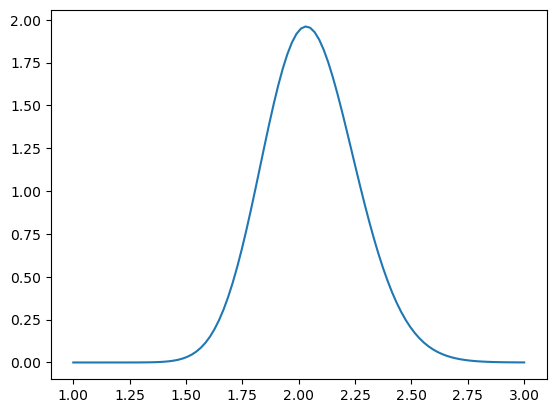

In [17]:
plt.plot(lam_list,obj_list)

b) The likelihood is a function of $\lambda$ with $X$ fixed was given above as
$$
p(X\vert \lambda) = \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)
$$
The prior is $p(\lambda) = \text{Norm}(\lambda,0.5), \lambda\in [1,3]$. 
<br>
Then the posterior probability is the probability of $\lambda$ given the $X$:
$$
p(\lambda\vert X) = \frac{p(X\vert\lambda)p(\lambda)}{\int p(X\vert\lambda)p(\lambda)d\lambda}
$$
$$
= \frac{\lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)\text{Norm}(\lambda,0.5)}{\int_1^3 \lambda^N\exp\left(-\lambda\sum_{i=1}^N x_i\right)\text{Norm}(\lambda,0.5)d\lambda}
$$

In [18]:
#b)
def integrand2(lam): #denominator & numerator
    return lam**N1 * np.exp(-lam*np.sum(X1)) * stats.norm.pdf(lam,3,0.5)
denom2 = integrate.quad(integrand2, 1, 5) #denominator

def post2(lam): #this is the posterior
    return integrand2(lam)/denom2[0]

In [19]:
#double checking that our posterior integrates to 1
integrate.quad(post2,1,3)[0]

0.9998978417148642

In [20]:
obj_list = []
lam_list = []
for lam in np.linspace(1,3,1000):
    obj_list.append(post2(lam))
    lam_list.append(lam)

lam_list[np.argmax(obj_list)]

2.1791791791791795

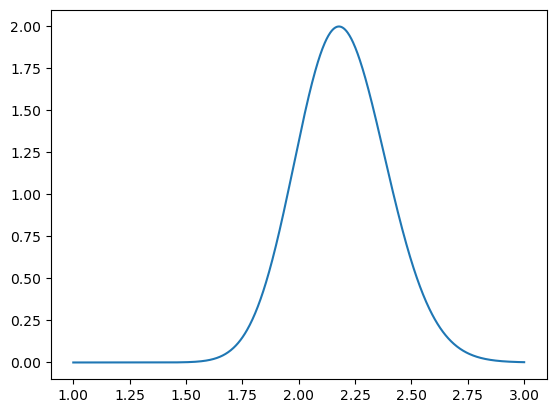

In [21]:
plt.plot(lam_list,obj_list)

#### 3.

In [22]:
#2)
#lets find the maximum of the posterior:
def obj_fun1(lam):
    return -1*post1(lam)
#lets find the maximum of the posterior:
def obj_fun2(lam):
    return -1*post2(lam)
min_a = minimize(obj_fun1, 1.1, method = "Nelder-Mead")
print(min_a)
min_b = minimize(obj_fun2, 1.1, method = "Nelder-Mead")
print(min_b)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -1.9609677256512998
             x: [ 2.033e+00]
           nit: 17
          nfev: 34
 final_simplex: (array([[ 2.033e+00],
                       [ 2.033e+00]]), array([-1.961e+00, -1.961e+00]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -1.9983897905927663
             x: [ 2.178e+00]
           nit: 18
          nfev: 36
 final_simplex: (array([[ 2.178e+00],
                       [ 2.178e+00]]), array([-1.998e+00, -1.998e+00]))


## The Problem

From Bayesian hierarchical model, we focus on level 2 for hyperparameter selection:

2. Bayes' rule for the posterior over the hyperparameters: here the marginal likelihood from level 1. takes the role of the likelihood:
$$
p(\theta\vert y,X) = \frac{p(y\vert X,\theta)p(\theta)}{p(y\vert X)}
$$
where $p(\theta)$ is the hyper-prior (prior distribution for hyperparameters) and the marginal likelihood
$$
p(y\vert X) = \int p(y\vert X,\theta)p(\theta) d\theta
$$
and the likelihood
$$
p(y\vert X,\theta) = \int p(y\vert X, f)p(f\vert \theta) df
$$
is the marginal likelihood in level 1.
<br><br><br>

**Aproach 1: Type II maximum likelihood (we have done before, see Hyperparameter_Kernel_Selection notebook)**

We have $m$ hyperparameters $\theta = (\theta_1,\ldots,\theta_m)$ in our GP model based on observations $(X,y)$, and the covariance function $K$ is a function of $\theta$, so we write the marginal likelihood conditioned on the hyperparameters $\theta$. If our goal is to maximize the marginal likelihood $p(y\vert X,\theta)$ from level 1 with respect to $\theta$, where $\theta$ is unknown and $(X,y)$ is our observed data, then the aproximation is called a _type II maximum likelihood_. That is, we want to find the _maximum marginal likelihood_
$$
\hat{\theta} = \text{argmax}_\theta p(y\vert X,\theta)
$$

Let's write $y\sim N(0,K+\sigma_n^2I) = N(0,K_y)$, where $K = k(X,X)$ and $K_y$ depend on $X,\theta$ (for $K_y$, $\theta$ includes $\sigma_n$). Then,
$$
p(y\vert X,\theta) = (2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y]
$$
which we rewrite as the marginal log-likelihood
$$
\ln(p(y\vert X,\theta)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y.
$$
<br><br><br>

**Approach 2: Integratation**
We would like to find the posterior
$$
p(\theta\vert y,X) = \frac{p(y\vert X,\theta)p(\theta)}{p(y\vert X)}
$$
<br>
$$
= \frac{p(y\vert X,\theta)p(\theta)}{\int p(y\vert X,\theta)p(\theta) d\theta}
$$
<br>
$$
= \frac{\left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y] \right)p(\theta)}{\int \left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y] \right)p(\theta) d\theta}
$$
<br>
We've already done approach 1 before, so we'll do approach 2. We find the posterior using Markov chain Monte Carlo (MCMC) methods.

## Explanation of MCMC

### Basic Monte Carlo Integration
Before we go into MCMC, let's investigate how to numerically estiamte the integration of a function $f(x)$ using a Monte Carlo method. Our goal is to solve the following integration problem:
$$
F = \int_{x\in D} f(x) dx
$$
We can express this as an expectation problem:
$$
F = \int_{x\in D} \frac{f(x)}{p(x)}p(x)dx = \int_{x\in D} g(x)p(x)dx = E[g(x)] = E\left[\frac{f(x)}{p(x)}\right]
$$
where $p(x)$ is the pdf of our sampling distro (like a proposal distribution in MCMC). We can approximate the integral with a sum:
$$
E[g(x)] \approx \frac{1}{N}\sum_{i=1}^N g(x_i) = \frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{p(x_i)}
$$
By the Strong Law of Large Numbers,
$$
P(\lim_{N\rightarrow\infty}F^N = F) = 1
$$
For example, we're sampling from a 1D uniform distro, then the $N$ uniform variables $X_i\in [a,b)$ with pdf $p(x) = 1/(b-a)$, so
$$
\hat{F^N} = (b-a)\frac{1}{N}\sum_{i=1}^N f(x_i)
$$
While there exists standard integration techniques which converge much faster in one dimension, they suffer from the curse of dimensionality where the convergence rate becomes exponentially worse in higher dimensions. The Monte Carlo estimator is unaffected by the number of dimensions, making it the only practical technique for high dimensional integration problems.
<br><br><br>
Variance of $F^N$:
$$
\text{Var}[\hat{F^N}] = \frac{1}{N}\text{Var}\left[\frac{f(x_i)}{p(x_i)}\right]
$$
How to reduce variance? Try **importance sampling**: choose samples from a distribution $p(x)$ which has a similar shape as $f(x)$. Importance sampling attempts to sample where the contribution of the integrand is high (important).
<br>
1) If $f(x) = g(x)h(x)$,  we can construct a pdf such that $p(x)$ is proportional to $g(x)$:
$$
\frac{1}{N}\sum_{i=1}^N \frac{f(x_i)}{p(x_i)} = \frac{1}{N}\sum_{i=1}^N \frac{g(x_i)h(x_i)}{cg(x_i)} = \frac{1}{cN}\sum_{i=1}^N h(x_i)
$$
2) Choose $g(x)$ where its analytical integral is known and $\frac{f(x_i)-g(x_i)}{p(x_i)}$ is close to a constant.
3) Stratified sampling: split the original integral into a sum of integrals over sub-domains (strata). We can split the domain $[a,b]$ into $N$ sub-domains. With a uniform pdf with $\epsilon_i\in[0,1)$, we have
$$
\hat{F^N} = (b-a)\frac{1}{N}\sum_{i=1}^N f\left(a+\frac{i+\epsilon_i}{N}(b-a)\right)
$$

<br><br><br>
Sources used
- https://cs.dartmouth.edu/~wjarosz/publications/dissertation/appendixA.pdf

Coding references
- https://towardsdatascience.com/the-basics-of-monte-carlo-integration-5fe16b40482d
- https://boyangzhao.github.io/posts/monte-carlo-integration

### MCMC
#### 1. Bayesian inference
Why MCMC? It allows us to simulate values from an unknown distro.

Bayesian inference:
- access to observations $y$ in light of underlying data $X$ to make predictions as a function of parameters $\theta$
- $p(y\vert X,\theta)$ is the likelihood of $\theta$ based on $y$

By Bayes theorem
$$
p(\theta\vert y,X) = \frac{p(y\vert X,\theta)p(\theta)}{\int p(y\vert X,\theta)p(\theta) d\theta}
$$
where
$$
\int p(y\vert X,\theta)p(\theta) d\theta
$$
is the evidence or marginal likelihood because the GP model for $X$ is marginalized (integrated) over all possible parameter values $\theta$.
<br>
Let's rewrite posterior as
$$
P(\theta) = \frac{L(\theta)p(\theta)}{\int L(\theta)p(\theta)d\theta} = \frac{\tilde{P}(\theta)}{\int \tilde{P}(\theta)d\theta} = \frac{\tilde{P}(\theta)}{Z}
$$
where $\tilde{P}(\theta) = ZP(\theta)$ is the unnormalized posterior. Our goal is to find the following:
$$
E_p[f(\theta)] = \frac{\int f(\theta)\tilde{P}(\theta)d\theta}{\int \tilde{P}(\theta)d\theta} = \int f(\theta)P(\theta)d\theta
$$
so we want to use the posterior to propose a point estimate $\hat{\theta}$ for $\theta$.
<br><br><br><br>

#### 2. Estimating integrals using grids
1D case: Riemann sum of $n$ rectangels over discrete grid of points
$$
E_p[f(\theta)] = \int f(\theta)P(\theta)d\theta = \frac{\int f(\theta)\tilde{P}(\theta)d\theta}{\int \tilde{P}(\theta)d\theta} \approx \sum_{i=1}^n f(\theta_i)P(\theta_i)\Delta\theta_i = \frac{\sum_{i=1}^n f(\theta_i)\tilde{P}(\theta_i)\Delta\theta_i}{\sum_{i=1}^n \tilde{P}(\theta_i)\Delta\theta_i}
$$
where $\theta_{i+1}-\theta_i$ and $\theta_i = (\theta_{i+1}+\theta_i)/2$. In ND case with $n$ cuboids, $\Delta\theta_i = \prod_{j=1}^d\Delta_{i,j}$ for the $i$th cuboid in the $j$th dimension.
<br>
Problems:
1) $n$ grid points increases exponentially as dimension $d$ increases, the curse of dimensionality
2) contribution of each portion of grid points uneven, so effectiveness also depends on where the $n$ points are
3) The limit as $N\rightarrow\infty$ of the integral approximation may converge, but only if the grid covers the entire domain of $\theta$ would the grid method be a consistent estimator, which is impossible in practice.

<br>
Solution: MCMC
<br>

For problem 2), we can think of the approximation as a weighted sum:
$$
E_p[f(\theta)] = \frac{\sum_{i=1}^n f(\theta_i)\tilde{P}(\theta_i)\Delta\theta_i}{\sum_{i=1}^n \tilde{P}(\theta_i)\Delta\theta_i} = \frac{\sum_{i=1}^n w_i f(\theta_i)}{\sum_{i=1}^n w_i}
$$
<br>
Our effective sample size (ess), depending on the weights, is $n_{eff}<n$. In theory, $n_{eff} = (\sum w_i)^2/(\sum w_i^2)$
<br><br><br><br>

#### 3. Monte Carlo methods
Goal: estimate $E_p[f(\theta)]$ using a grid of $n$ points to an equivalent estimation of $n$ samples $\{f(\theta_1),\ldots,f(\theta_n)\}$ and associated weights $\{w_1,\ldots,w_n\}$, but we also want to addaptively increase resolution of the grid, that is, adjust $\Delta\theta_i$ such that the weights $w_i = \tilde{P}(\theta_i)\Delta\theta_i$ are uniform to some precision, so we want
$$
\Delta\theta_i \propto \frac{1}{\tilde{P}(\theta_i)}
$$
Let's define the pdf $Q(\theta)$ from some _proposal distribution_ $Q$ based on varying resolution of points $\Delta\theta(\theta)$:
$$
Q(\theta) \propto \frac{1}{\Delta\theta(\theta)}
$$
so
$$
E_p[f(\theta)] = \frac{\int f(\theta)\tilde{P}(\theta)d\theta}{\int \tilde{P}(\theta)d\theta} = \frac{\int f(\theta)\frac{\tilde{P}(\theta)}{Q(\theta)}Q(\theta)d\theta}{\int \frac{\tilde{P}(\theta)}{Q(\theta)}Q(\theta)d\theta} = \frac{E_Q[f(\theta)\tilde{P}(\theta)/Q(\theta)]}{E_Q[\tilde{P}(\theta)/Q(\theta)]}
$$

we do this because we can estimate the expressions using a series of $n$ randomly generated samples from $Q(\theta)$. This is called a Monte Carlo approach for estimating the expectation (see MC Integration method above). Drawing $n$ samples from $\{\theta_1,\ldots,\theta_n\}$ from $Q(\theta)$ is inherently random, a stochastic process. Since the $n$ samples are generated randomly from $Q(\theta)$ over the entire sample space, we can guarantee $Q(\theta)$ will provide sufficient coverage over all possible $\theta$, so Monte Carlo methods are consistent estimators.
<br><br>

(#1): If we let $\tilde{P}(\theta_i)/Q(\theta_i) = \tilde{w}(\theta_i)$,
$$
E_p[f(\theta)] = \frac{E_Q[f(\theta)\tilde{w}(\theta)]}{E_Q[\tilde{w}(\theta)]} \approx \frac{\sum_{i=1}^n f(\theta_i)\tilde{w}(\theta_i)Q(\theta_i)}{\sum_{i=1}^n \tilde{w}(\theta_i)Q(\theta_i)}
$$
<br><br>

If we assume that _proposal distribution_ $Q(\theta)$ has the 1D uniform distribution, then $Q(\theta_i) = 1/n$ and $\tilde{w}(\theta_i) = \tilde{P}(\theta_i)$ so
$$
E_p[f(\theta)] \approx \frac{n^{-1}\sum_{i=1}^n f(\theta_i)\tilde{w}(\theta_i)}{n^{-1}\sum_{i=1}^n \tilde{w}(\theta_i)}
$$
and observe that
$$
Z = \int \tilde{P}(\theta)d\theta \approx \frac{1}{n}\sum_{i=1}^n \tilde{w}(\theta_i)
$$
which is simply a Monte Carlo integral estimate of the evidence in the posterior.
<br><br><br>

The above method in (#1) is called _importance sampling_ where $\tilde{w}(\theta_i)$ are the _importance weights_. Instead of the uniform, we could choose $Q(\theta)=p(\theta)$ the prior.Then $\tilde{w}(\theta_i) = L(\theta_i)$. The optimal strategy would be to use $Q(\theta) = P(\theta)$ so that $\tilde{w}(\theta_i) = Z$ which generates the maximum possible ess of the parameter space. This is the motivation behind MCMC.
<br><br><br><br>

#### 4. Markov Chain Monte Carlo (MCMC) via the Metropolis-Hastings Algorithm
Goal: create a _chain_ of correlated parameter values $\{\theta_1\rightarrow \cdots \rightarrow \theta_n\}$ over $n$ iterations such that the number of iterations $m(\theta_i)$ spent on any region $\delta_{\theta_i}$ centered on $\theta_i$ is proportional to $P(\theta_i)$ contained within $\delta_{\theta_i}$. We want the limiting behavior to reduce to a chain of samples whose distribution follows the posterior.
<br><br>

The _Metropolis-Hastings_ algorithm can draw samples from any probability density $P(\theta)$, which is the posterior in this case, provided that we know $\tilde{P}(\theta)$ which is proportional to $P(\theta)$. At iteration $i$ the method used to propose a candidate $\theta_i$ is by sampling from the proposal distribution $Q(\theta_i\vert \theta_{i-1})$. A common choice for $Q(\theta_i\vert\theta_{i-1})$ is a normal distribution centered at $\theta_{i-1}$, making the chain a _Gaussian random walk_. The algorithm is as follows:

0) Choose an arbitrary starting point $\theta_0$ to be the first observation in the sample. Beginning from iteration $i=1$, choose a symmetric proposal pdf $Q(\theta_i\vert \theta_{i-1})$.

For each iteration $i$,
1) Propose a new position $\theta_{i-1}\rightarrow \theta_i'$ by generating a sample from $Q(\theta_i'\vert \theta_{i-1})$
2) Compute the _transition probability_ (_acceptance ratio_)
$$
\alpha = T(\theta_{i}'\vert\theta_i) = \min\left[\frac{P(\theta_i')Q(\theta_{i-1}\vert \theta_i')}{P(\theta_{i-1})Q(\theta_i'\vert \theta_{i-1})} , 1 \right] = \min\left[\frac{\tilde{P}(\theta_i')Q(\theta_{i-1}\vert \theta_i')}{\tilde{P}(\theta_{i-1})Q(\theta_i'\vert \theta_{i-1})} , 1 \right]
$$
<br>
since $P$ is proportional to $\tilde{P}$. If the proposal distribution $Q$ is symmetric, then the pdfs $Q(\theta_i'\vert \theta_{i-1}) = Q(\theta_{i-1}\vert \theta_i')$ and so
<br>
$$
\alpha = T(\theta_{i}'\vert\theta_i) = \min\left[\frac{\tilde{P}(\theta_i')}{\tilde{P}(\theta_{i-1})} , 1 \right]
$$
3) Generate a random uniform number $u_{i}\sim U(0,1)$.
4) If $u_i\leq \alpha$, accept the proposal by setting $\theta_i = \theta_i'$. Else, reject the proposal and set $\theta_i = \theta_{i-1}$.

<br><br><br>

This method generates a chain of states where the next proposed position depends only on the current position (forgets the past), making it a _Markov process_. Since we must guess $\theta_0$, we remove initial chain of states from the sample once the chain begins to sample from higher probability regions, known as a _burn-in_.

$\theta_i$ is likely to be correlated with $\theta_{i-1}$ and $\theta_{i+1}$. If the acceptance ratio is low, we increase in overall correlation. The auto-covariance $C(t)$ for iteration lag $t$ is
$$
C(t) = \lim_{n\rightarrow\infty}\frac{1}{n}\sum_{i=1}^n(\theta_{i}-\bar{\theta})\cdot(\theta_{i+t}-\bar{\theta})
$$
and the _autocorrelation_ is
$$
A(t) = \frac{C(t)}{C(0)}
$$
with auto-correlation time
$$
\tau = 2\sum_{t=1}^\infty A(t)
$$
and
$$
n_{eff}' = \frac{n_{eff}}{1+\tau}
$$

<br><br><br><br>

Sources
- https://arxiv.org/pdf/1909.12313.pdf

Literature references
- https://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf
- https://arxiv.org/pdf/2304.02595.pdf

Coding references
- https://boyangzhao.github.io/posts/mcmc-bayesian-inference
- https://people.duke.edu/~ccc14/sta-663/MCMC.html
- https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

### 1D Examples of MCMC implementation

##### Example 1
Generate $N(0,1)$ using the random walk Metropolis algorithm based on proposal distribution $Q(\theta_i'\vert \theta_{i-1}) \sim \text{Unif}(\theta_{i-1}-a, \theta_{i-1}+a)$.

C:\Users\Sasha\AppData\Local\Temp\ipykernel_11832\1277603279.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(C, bins=30, kde=True, hist=True, color='orange', label="Aprox", hist_kws={'alpha':0.3})


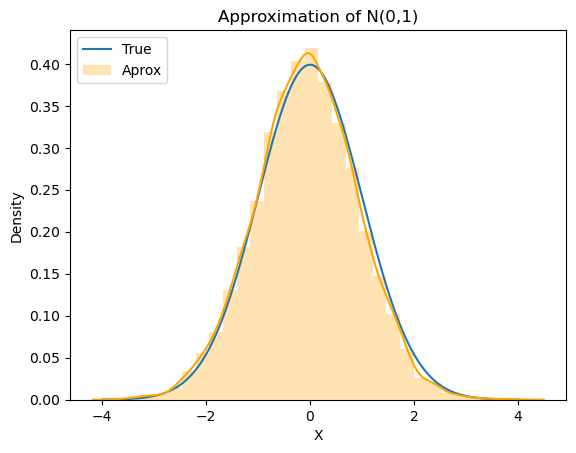

In [81]:
a = 1
N = 20000
theta = np.zeros(N)
theta[0] = 0  # first value of theta in the Markov chain is 0.

for i in range(1, N):
    #1) Propose new position x[i-1] -> x[i]' by sampling from proposal distro
    theta_prop = np.random.uniform(theta[i-1]-a, theta[i-1]+a) #x[i]'

    #2) Compute transition probability
    f_prop = stats.norm.pdf(theta_prop, 0, 1) #~P(theta_i')
    f_prev = stats.norm.pdf(theta[i-1], 0, 1)  #~P(theta_{i-1})
    
    alpha = min(f_prop/f_prev, 1)  # Acceptance ratio
    
    #3) Generate a random number u_i from [0,1]
    u = np.random.uniform(0,1) #u_i
    
    if u <= alpha:
        theta[i] = theta_prop  # Accept y as next state
    else:
        theta[i] = theta[i-1]  # Stay at previous state of Markov chain

C = theta

# Plot of true density function
x = np.linspace(-4,4,1000)
plt.plot(x, stats.norm.pdf(x, 0, 1), label="True")

# Plot of MCMC approximation
sns.distplot(C, bins=30, kde=True, hist=True, color='orange', label="Aprox", hist_kws={'alpha':0.3})

plt.xlabel('X')
plt.ylabel('Density')
plt.title('Approximation of N(0,1)')
plt.legend(loc='upper left')
plt.show()